<a href="https://www.quantrocket.com"><img alt="QuantRocket logo" src="https://www.quantrocket.com/assets/img/notebook-header-logo.png"></a><br>
<a href="https://www.quantrocket.com/disclaimer/">Disclaimer</a>

***
[Fundamental Factors](Introduction.ipynb) › Lesson 9: Sector Neutralization
***

# Sector Neutralization
Sector neutralization is a technique to neutralize sector exposures by ranking and comparing factors separately within each sector rather than comparing companies across the entire market. This is done to hedge out sector bets and reduce the impact of sector-specific risks on the portfolio.

Many fundamental metrics naturally vary across sectors and industries. These variations don't necessarily indicate better or worse companies but simply represent differences in the way different industries operate. Sector neutralization can be useful with these kinds of metrics.

In this notebook we'll use the debt-to-equity ratio (D/E ratio) to explore sector neutralization.

## Sector Differences in D/E Ratio

Let's start by looking at how the D/E ratio varies across sectors. To do so, we define a pipeline for our base universe, with the D/E ratio and sector as columns:

In [1]:
from zipline.pipeline import master, sharadar, Pipeline
from codeload.fundamental_factors.universe import CommonStocks, BaseUniverse

fundamentals = sharadar.Fundamentals.slice('ART')
de = fundamentals.DE.latest

sector = master.SecuritiesMaster.sharadar_Sector.latest

universe = BaseUniverse()

pipeline = Pipeline(
    columns={
        'de': de,
        'sector': sector
    },
    initial_universe=CommonStocks(),
    screen=universe
)

Then we run the pipeline, group the results by sector, and plot the median D/E ratio for each sector:

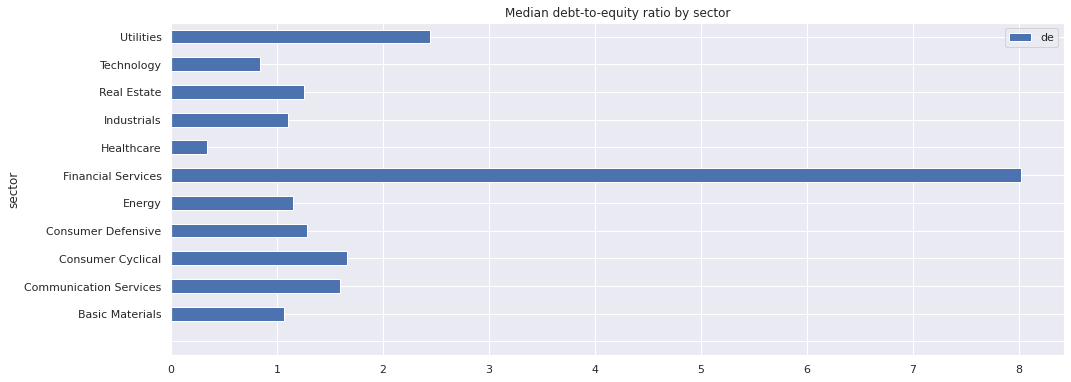

In [2]:
from zipline.research import run_pipeline

results = run_pipeline(pipeline, '2022-12-30', '2022-12-30')
results.groupby('sector').median().plot(kind="barh", title="Median debt-to-equity ratio by sector");

The median D/E ratio for the financial sector is much higher than for other sectors, and the D/E ratio for the healthcare sector is considerably lower than for other sectors. This means that if we rank stocks by their D/E ratio, the financial sector will be over-represented at one end of the rankings and the healthcare sector will be over-represented at the other end.

## Sector Concentration

Let's visualize this over-representation. To do so, we'll rank by D/E ratio in ascending order (that is, assigning ranking 1 to the lowest D/E ratio) and form quintiles from the ranks. We will then be able to analyze the sector representation in the highest and lowest quintiles, respectively. 

In [3]:
pipeline = Pipeline(
    columns={
        # we mask rank() with universe to avoid ranking stocks that aren't in our universe
        'quintiles': de.rank(mask=universe).quintiles(),
        'sector': sector,     
    },
    initial_universe=CommonStocks(),
    screen=universe
)

results = run_pipeline(pipeline, '2022-12-30', '2022-12-30')

To establish a baseline, let's count the number of securities per sector to see how different sectors compare in size. We can see that Financial Services, Healthcare, Technology, and Industrials are the largest sectors in the market:

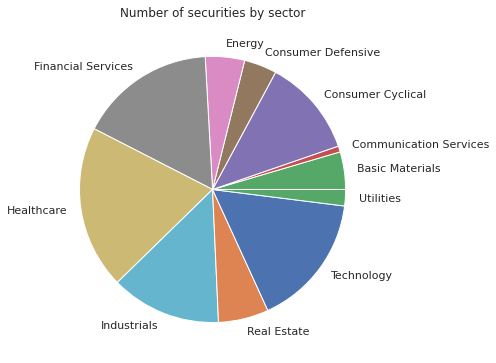

In [4]:
securities_by_sector = results.groupby('sector').quintiles.count()
ax = securities_by_sector.plot(kind="pie", title="Number of securities by sector")
ax.set_ylabel('');

Now, let's count the number of securities per sector in the lowest and highest quintiles by D/E ratio. The quintile labels are zero-indexed, meaning quintile 0 contains stocks with the lowest D/E ratios, and quintile 4 contains stocks with the highest D/E ratios. 

In [5]:
lowest_quintile_by_sector = results[results.quintiles == 0].groupby('sector').quintiles.count()
highest_quintile_by_sector = results[results.quintiles == 4].groupby('sector').quintiles.count()

We then view pie charts of the results. As expected, healthcare stocks dominate the low D/E quintile, and financial stocks dominate the high D/E quintile. Consequently, a long-short portfolio formed using the D/E ratio would largely be just a bet on healthcare vs financials:

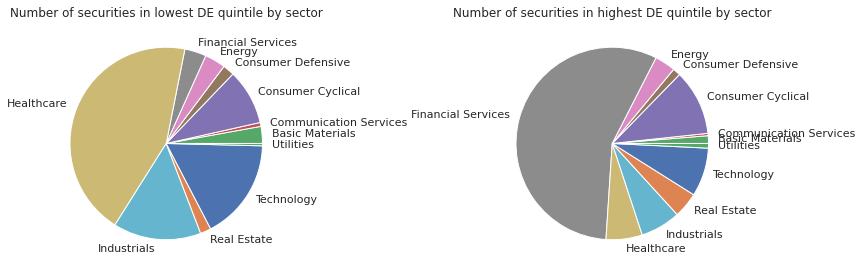

In [6]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

lowest_quintile_by_sector.plot(kind="pie", ax=axes[0], title="Number of securities in lowest DE quintile by sector")
highest_quintile_by_sector.plot(kind="pie", ax=axes[1], title="Number of securities in highest DE quintile by sector")

for ax in axes:
    ax.set_ylabel('')

fig.tight_layout()

## Sector-Neutral Ranking

To avoid sector concentration, we can incorporate the sector into the ranking process by using the `groupby` parameter of `rank()`. Normally, the `rank()` method ranks all securities from $1 \rightarrow N$, where $N$ is the number of securities in the universe. In contrast, `rank(groupby=sector)` ranks securities from $1 \rightarrow N$ within each sector, where $N$ is the number of securities in the sector. In the resulting output, if there are $S$ sectors, there will be $S$ stocks ranked 1, $S$ stocks ranked 2, etc. Ranking by sector will allow us to form a portfolio in which each sector is equally represented.

The following pipeline expression ranks by sector, then forms quintiles from the resulting ranks: 

In [7]:
neutral_quintiles = de.rank(mask=universe, groupby=sector).quintiles()

Let's re-run the previous pipeline with the neutral quintiles to see how this affects the composition of our low D/E quintile: 

In [8]:
pipeline = Pipeline(
    columns={
        'quintiles': de.rank(mask=universe).quintiles(),
        'neutral_quintiles': neutral_quintiles,
        'sector': sector,     
    },
    initial_universe=CommonStocks(),
    screen=universe
)

results = run_pipeline(pipeline, '2022-12-30', '2022-12-30')

We plot the sector breakdown of the low DE quintile without sector neutralization (on the left) and with sector neutralization (on the right). Sector neutralization has eliminated the over-weighting of healthcare and created balance across sectors: 

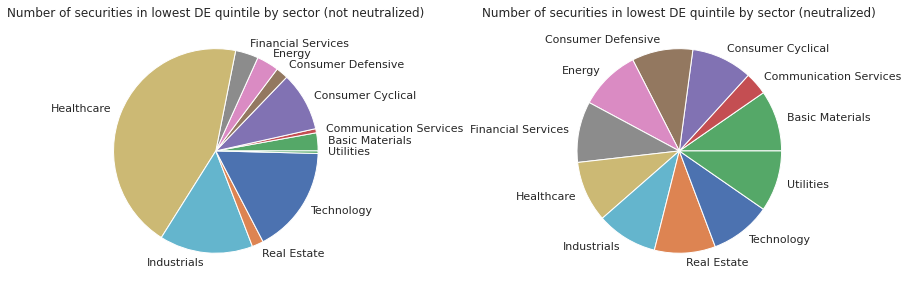

In [9]:
lowest_quintile_by_sector_neutralized = results[results.neutral_quintiles == 0].groupby('sector').neutral_quintiles.count()

import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

lowest_quintile_by_sector.plot(kind="pie", ax=axes[0], title="Number of securities in lowest DE quintile by sector (not neutralized)")
lowest_quintile_by_sector_neutralized.plot(kind="pie", ax=axes[1], title="Number of securities in lowest DE quintile by sector (neutralized)")

for ax in axes:
    ax.set_ylabel('')

fig.tight_layout()

## Beware of the highest quintile

Let's create a similar set of plots for the high D/E quintile, to see if we have eliminated the over-weighting of financial stocks in this quintile:

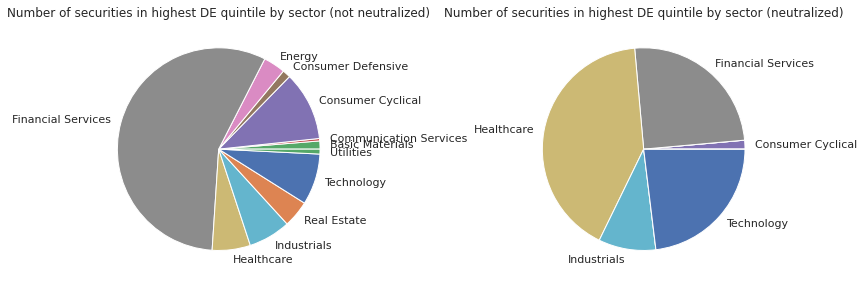

In [10]:
highest_quintile_by_sector_neutralized = results[results.neutral_quintiles == 4].groupby('sector').neutral_quintiles.count()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

highest_quintile_by_sector.plot(kind="pie", ax=axes[0], title="Number of securities in highest DE quintile by sector (not neutralized)")
highest_quintile_by_sector_neutralized.plot(kind="pie", ax=axes[1], title="Number of securities in highest DE quintile by sector (neutralized)")

for ax in axes:
    ax.set_ylabel('')

fig.tight_layout()

That doesn't look good! The sector-neutralized, high D/E quintile (right-hand plot) is now highly concentrated in four sectors: Healthcare, Financial Services, Technology, and Industrials. What's going on? You may notice that these four sectors are the four largest sectors, as we saw earlier. When we rank by sector using `rank(groupby=sector)`, the stocks in each sector are ranked from $1 \rightarrow N$, where $N$ is the number of securities in the sector. This means that larger sectors end up having securities with larger maximum ranks. As a result, when we get to the last quintile (which contains stocks with high ranks), only the larger sectors have any securities left to put in the quintile.

This means that if you want to construct a sector-neutralized high D/E quintile, you should not use quintile 4 of the D/E ratio ranked by sector in ascending order. Rather, you should form quintiles from D/E ratio ranked by sector in *descending* order (highest D/E ratio first) and select quintile 0.

This is the approach used by the `top()` and `bottom()` Factor methods in Pipeline, so you can avoid the above problem by using those methods to select high and low D/E stocks. The following code selects the 10 stocks from each sector with the lowest D/E ratio and the 10 stocks from each sector with the highest D/E ratio:

In [11]:
# this ranks D/E from low to high and takes the first 10 per sector
lowest_de_stocks = de.bottom(10, mask=universe, groupby=sector)

# this ranks D/E from high to low and takes the first 10 per sector
highest_de_stocks = de.top(10, mask=universe, groupby=sector)

To double-check that this results in the sector balance we expect, let's create a pipeline containing the low D/E and high D/E groups of stocks we just selected. We use the `if_else()` Filter method combined with `Constant()` to  label the groups as "low" and "high", respectively:

In [12]:
from zipline.pipeline import Constant

# limit the output to the low DE and high DE stocks we just selected
screen = lowest_de_stocks | highest_de_stocks

# label the two groups of stocks (if_else() returns the first argument 
# if lowest_de_stocks is True and the second argument if it is False)
label = lowest_de_stocks.if_else(Constant('low'), Constant('high'))

pipeline = Pipeline(
    columns={
        'label': label,
        'sector': sector
    },
    initial_universe=CommonStocks(),
    screen=screen
)

Running this pipeline, we confirm that there are 10 stocks per sector in the low and high D/E groups:

In [13]:
results = run_pipeline(pipeline, start_date="2022-12-30", end_date="2022-12-30")
results['label'] = results.label.cat.remove_unused_categories()
results.groupby(['label', 'sector']).size()

label  sector                
high                              0
       Basic Materials           10
       Communication Services    10
       Consumer Cyclical         10
       Consumer Defensive        10
       Energy                    10
       Financial Services        10
       Healthcare                10
       Industrials               10
       Real Estate               10
       Technology                10
       Utilities                 10
low                               0
       Basic Materials           10
       Communication Services    10
       Consumer Cyclical         10
       Consumer Defensive        10
       Energy                    10
       Financial Services        10
       Healthcare                10
       Industrials               10
       Real Estate               10
       Technology                10
       Utilities                 10
dtype: int64

## Demeaning by Sector

Another way to neutralize sectors is to demean them. With demeaning, we calculate the mean D/E ratio for each sector and subtract it from the observed values. Accordingly, the resulting values are centered around zero for each sector, which allows us to better compare values across sectors. If we rank stocks on their demeaned D/E ratios, we are ranking them not on their absolute D/E ratio but on how high or low their D/E ratio is relative to the sector average.   

The following pipeline expression forms quintiles from sector-demeaned D/E ratios: 

In [14]:
demeaned_quintiles = de.demean(mask=universe, groupby=sector).quintiles()

## Z-Scoring by Sector

Alternatively, we can z-score the D/E ratios, which is like demeaning but includes the additional step of dividing the demeaned values by the standard deviation of D/E ratios for the sector. Whereas demeaning neutralizes the effect of one sector having generally higher or lower D/E ratios than another sector, z-scoring additionally removes the effect of one sector having a wider variation of D/E ratios than another sector.

To z-score in Pipeline, just modify the previous expression to use `zscore()` instead of `demean()`:

In [15]:
zscored_quintiles = de.zscore(mask=universe, groupby=sector).quintiles()

Note that, unlike the ranking approaches shown above, demeaning and z-scoring don't guarantee that your quantiles will be equally weighted among all sectors. It is still possible that the best or worst D/E ratios will cluster more in one sector than another, even after adjusting for sector differences. Moreover, since some sectors are larger than others, we should naturally expect that those larger sectors will make up a larger portion of any given quantile, on average. 

## Should you neutralize by industry or sector?

An alternative to neutralizing by sector is to neutralize by industry. Industries are more specific than sectors. In theory, the appeal of using industries instead of sectors is that companies within a given industry are more closely related than companies within a given sector, thus providing a more accurate benchmark. However, many industries are too small to allow for meaningful comparisons. For this reason, sectors usually provide a better balance of granularity and adequate sample size. Industries are best used when you wish to specifically target a particular industry or group of industries, which you know in advance are large enough to yield meaningful results.  

The number of stocks per industry is shown below:

In [16]:
pipeline = Pipeline(
    columns={
        'sector': master.SecuritiesMaster.sharadar_Sector.latest,
        'industry': master.SecuritiesMaster.sharadar_Industry.latest,
    },
    initial_universe=CommonStocks(),
    screen=universe
)

results = run_pipeline(pipeline, '2022-12-30', '2022-12-30')
counts = results.groupby(['sector', 'industry']).size()
print(counts[counts > 0].to_string())

sector                  industry                                
Basic Materials         Agricultural Inputs                          10
                        Aluminum                                      3
                        Building Materials                            6
                        Building Products & Equipment                29
                        Chemicals                                    18
                        Coking Coal                                   5
                        Copper                                        2
                        Gold                                         11
                        Lumber & Wood Production                      4
                        Other Industrial Metals & Mining              5
                        Other Precious Metals & Mining                3
                        Paper & Paper Products                        6
                        Specialty Chemicals                          49

***

## *Next Up*

Lesson 10: [Macro Analysis](Lesson10-Macro-Analysis.ipynb)